<a id="libraries"></a>
# <b><span style='color:#ff6200'> Swiss and Roll Analysis</span></b>

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons

X,y = make_moons(n_samples = 500, noise = 0.25, random_state = 42)
df = pd.DataFrame(X, columns = ['x1','x2'])
df['y'] = y

<a id="libraries"></a>
# <b><span style='color:#ff6200'> Informations </span></b>

In [23]:
df.head()

,x1,x2,y
0,0.830948,-0.296546,1
1,1.088387,0.899693,0
2,1.135634,-0.462935,1
3,-0.082277,1.059718,0
4,0.443047,1.418977,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      500 non-null    float64
 1   x2      500 non-null    float64
 2   y       500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [25]:
df.describe()

,x1,x2,y
count,500.000000,500.000000,500.000000
mean,0.522681,0.256708,0.500000
std,0.910056,0.567666,0.500501
min,-1.608490,-1.117437,0.000000
25%,-0.096352,-0.193848,0.000000
50%,0.475017,0.281267,0.500000
75%,1.160498,0.706677,1.000000
max,2.641900,1.635114,1.000000


In [26]:
df.isna().sum()

x1    0
x2    0
y     0
dtype: int64

In [32]:
df.y.unique()

array([1, 0])

<a id="libraries"></a>
# <b><span style ='color:#ff6200'> Plots </span></b>

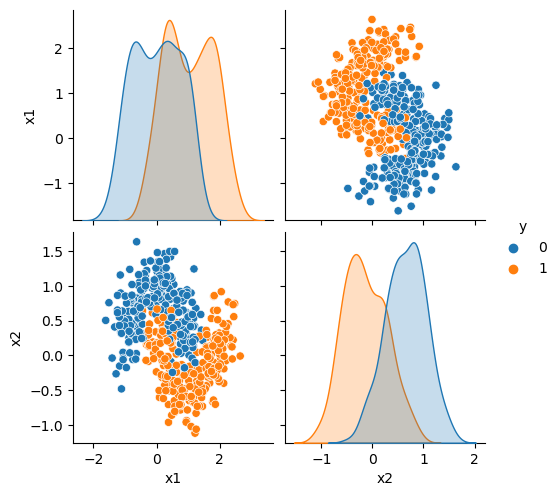

In [33]:
sns.pairplot(df,hue ='y')
plt.show()

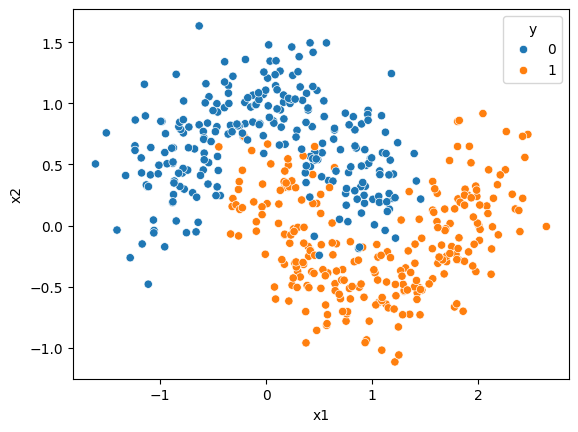

In [26]:
sns.scatterplot(x=df.x1, y = df.x2, hue = df.y)
plt.show()

Class are not linearly separable $\newline$
SVC with a kernel and ensemble methods (RandomForest classifier and boosting ) looks relevant in this case $\newline$
Due to the presence of some outiliers (confusion in classes), bagging algorithms look more relevant than boosting ones (especially Adaboost) which will too musch foxus on classifying these outliers.

<a id="libraries"></a>
# <b><span style ='color:#ff6200'> Correlation </span></b>

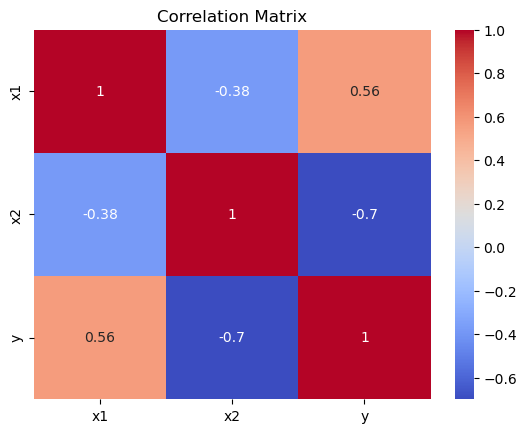

In [35]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix,annot=True,cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

<a id="libraries"></a>
# <b><span style ='color:#ff6200'> Split </span></b>

In [2]:
from sklearn.model_selection import train_test_split

X,y = df[['x1','x2']],df['y']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 42)

<a id="libraries"></a>
# <b><span style ='color:#ff6200'> Model Selection </span></b>

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Preprocessing and Pipeline

In [ ]:
pipe_svc = Pipeline([
    ('preprocessor', StandardScaler()),
    ('model', SVC())
])

pipe_rf = Pipeline([
    ('model', RandomForestClassifier()),
])

## Param grid search

In [12]:
param_grid_svm = [
    {'model__kernel': ['linear'],
     'model__C': [0.1]},
     {'model__kernel': ['rbf'],
      'model__C':[0.1,1,10,100],
      'model__gamma':['scale','auto',0.1,1,10]}
]

param_grid_rf = {
    'model__n_estimators' : [10,100,200],
    'model__max_depth' : [5,10,50]
}

## GridSearch for each params

In [13]:
grids = {}
for name,(pipe,params) in {'SVC' : (pipe_svc, param_grid_svm), 'RF' : (pipe_rf,param_grid_rf)}.items():
    grid = GridSearchCV(pipe,params, cv=5, scoring = 'accuracy', n_jobs = 1, verbose = 0)
    grid.fit(X_train,y_train)
    grids[name] = grid

## Compare Results

In [19]:
from sklearn.metrics import accuracy_score
results = []
for name, g in grids.items():
    results.append({
        'Model' : name,
        'Best score CV' : g.best_score_,
        'Test Accuracy' : accuracy_score(y_test,g.predict(X_test)),
        'Best Parameters': g.best_params_
    })
df_result = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending = False)
print('-'*30 + ' Performance Summary ' + '-'*30)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None) 
df_result

------------------------------ Performance Summary ------------------------------


,Model,Best score CV,Test Accuracy,Best Parameters
0,SVC,0.949333,0.960,"{'model__C': 1, 'model__gamma': 1, 'model__kernel': 'rbf'}"
1,RF,0.941333,0.952,"{'model__max_depth': 10, 'model__n_estimators': 100}"


## Decision Boundaries


 best_model = SVC


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


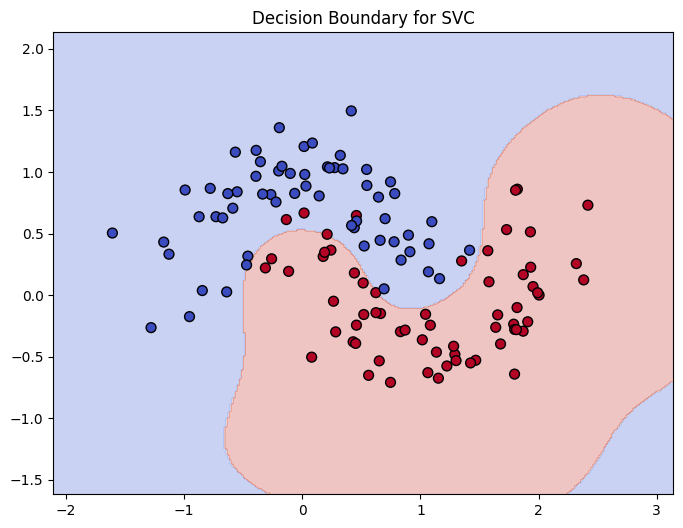

In [27]:
import numpy as np

best_model_name = df_result.iloc[0].Model
best_grid = grids[best_model_name]
best_pipe = best_grid.best_estimator_
print(f'\n best_model = {best_model_name}')

x0_range = np.linspace(X['x1'].min() - 0.5, X.x1.max()+0.5,300)
x1_range = np.linspace(X['x2'].min() - 0.5, X.x2.max()+0.5,300)

xx,yy = np.meshgrid(x0_range , x1_range)
Z = best_pipe.predict(np.c_[xx.ravel(),yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(8,6))
plt.contourf(xx,yy,Z,alpha=0.3,cmap ='coolwarm')
plt.scatter(X_test.x1, X_test.x2, c=y_test, cmap = 'coolwarm', s=50, edgecolor = 'k')
plt.title( f'Decision Boundary for {best_model_name}')
plt.show()